In [1]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats,signal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import KF2D
import pickle
import os,glob, csv
import cpd
from scipy.signal import hilbert

import numpy as np
from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import pdb
from __future__ import division


In [2]:
def findHW(data,fs=25,thresh = 0.02, filt = 'HPF'):
    N = len(data) #number samples

    HPF_mid = butter_highpass_lfilter(data,.2,25)#.1
    BPF_mid = butter_lowpass_lfilter(HPF_mid,2.5,25)#.9

    #make window
    x = len(BPF_mid[100:])
    Nx = int(pow(2, np.floor(np.log(x)-1/np.log(2)))); #find window size (nearest base 2 value less than length of data), based on length of values
    win = scipy.signal.get_window('hann',Nx=Nx)
    print('Window size is {}'.format(Nx))

    #start 100 timesteps in, to get rid of onset ringing
    if filt=='HPF':
        signal = HPF_mid
    elif filt == 'BPF':
        signal = BPF_mid
    elif filt == 'None':
        signal == data
        
    f_x, t_x, S_x = scipy.signal.spectrogram(signal[fs*2:],fs=fs,window=win,nfft=Nx,nperseg=Nx)#red_mat[:,2],fs) #x velocity

    thresh_f = next(x[0] for x in enumerate(f_x) if x[1] > 0) #frequency threshold
    print("Frequency threshold is {}".format(thresh_f))
    s_dt = np.diff(t_x)[0]   #timestep of spectrogram
    dt = np.diff(t_x)[0]*25

    print(np.mean(S_x),np.std(S_x))

    #plot spectrogram
    plt.figure()
    plt.pcolormesh(t_x+T[0], f_x, S_x, cmap='jet')
    plt.colorbar()
    plt.ylabel('Midpoint Frequency (Hz)') #previously "xdot freq" is this velocity? pretty sure this is position
    plt.xlabel('Time (s)')
    plt.ylim((0,fs/2))
    plt.show()

    #frame number where headwagging occurs
    head_wag = []
    head_wag_idx = []
    hw_freq = []

    #find where frequency is larger than some threshold. Currently 0.02, not sure why.
    for i in range(S_x.shape[1]-1):
        if max(S_x[thresh_f:,i])>=thresh:
#             print(i)
            head_wag.append(np.round(t_x.T[i] + T[0],2))# + s_dt*1.5)))
            hw_freq.append(f_x[list(np.where(S_x==max(S_x[thresh_f:,i]))[0])]) #finds dominant power frequency
            #hw_freq.append(f_x[thresh_f:,i])

    #get indices where head wagging is detected
    for i in range(len(head_wag)):
        if i==head_wag[i-1]+s_dt:
            continue
        else:
            try:
                head_wag_idx.append(list(np.where(np.round(T,2)==head_wag[i]+2)[0])[0])  #+T[0] deals with time offset between real time and spectrogram time
            except:
                print('Could not find time equal to {}. Check framerate and retry.'.format(np.round(head_wag[i],2)))
                
    hw_events = []
#     hw_cpd = []
    hw_vd = []
    hw_loc = []
    hw_bool = np.zeros(np.size(HPF_mid), dtype=bool)

    #TODO: make separate cell for hw_cpd, hw_vd
    for row in head_wag_idx:
#         pdb.set_trace()

        if row+Nx < len(signal):
            hw_loc.extend(range(row,row+Nx))
            hw_events.extend(data[row:row+Nx])#[row:row+Nx,0])
            hw_bool[row:row+Nx]=True
        else:
            hw_loc.extend(range(row,row+Nx))
            hw_events.extend(data[row:])#[row:,0])
            hw_bool[row:]=True
#         hw_cpd.append(spDens[row:row+Nx])#append  window range of spatial density values
#         hw_vd.append(view_dist[row:row+Nx])
    return hw_bool, HPF_mid, head_wag_idx, hw_freq

In [22]:
#For gap bridging data:
os.chdir('/Users/sazamore/Documents/headwagtrials/')
#If you want to open a file from another folder, create a new cell, type "cd" then "cd/FOLDER/FOLDER" to change the 
#working directory to the folder that contains your file.
# files = glob.glob('*raw.p')

def opencsv(filename):
    ID = int(filename[:2])

    raw_pd = pd.read_pickle(filename)
    raw_pd = raw_pd.T

    mid_KF = np.column_stack([raw_pd[0]/10,raw_pd[1]/10]) #convert to cm
    mid_mag = np.sqrt((raw_pd[2]/10)**2 + (raw_pd[3]/10)**2)
    # mid_mag.append([np.nan,np.nan])
    mid_norm = np.sqrt((raw_pd[0]/10)**2 + (raw_pd[1]/10)**2)
    return ID, raw_pd, mid_KF, mid_mag, mid_norm
#DATA IS IN MM!

In [547]:
os.chdir('/Users/sazamore/BehaviorVids/GapBridging')
mid_KF = pd.DataFrame.from_csv('119_snake95_position.csv',header=None, index_col = None)
mid_KF = np.column_stack([mid_KF[0].astype(float)/10,mid_KF[1].astype(float)/10])
mid_mag = np.sqrt(np.diff(mid_KF.T[0])**2 + np.diff(mid_KF.T[1])**2)
# mid_mag.append([np.nan,np.nan])
mid_norm = np.sqrt(mid_KF.T[0]**2 + mid_KF.T[1]**2)

# START!

File '95_gap4_3-raw.p' opened
Window size is 64
Frequency threshold is 1
(0.01675132346528569, 0.10010095472300361)


<IPython.core.display.Javascript object>


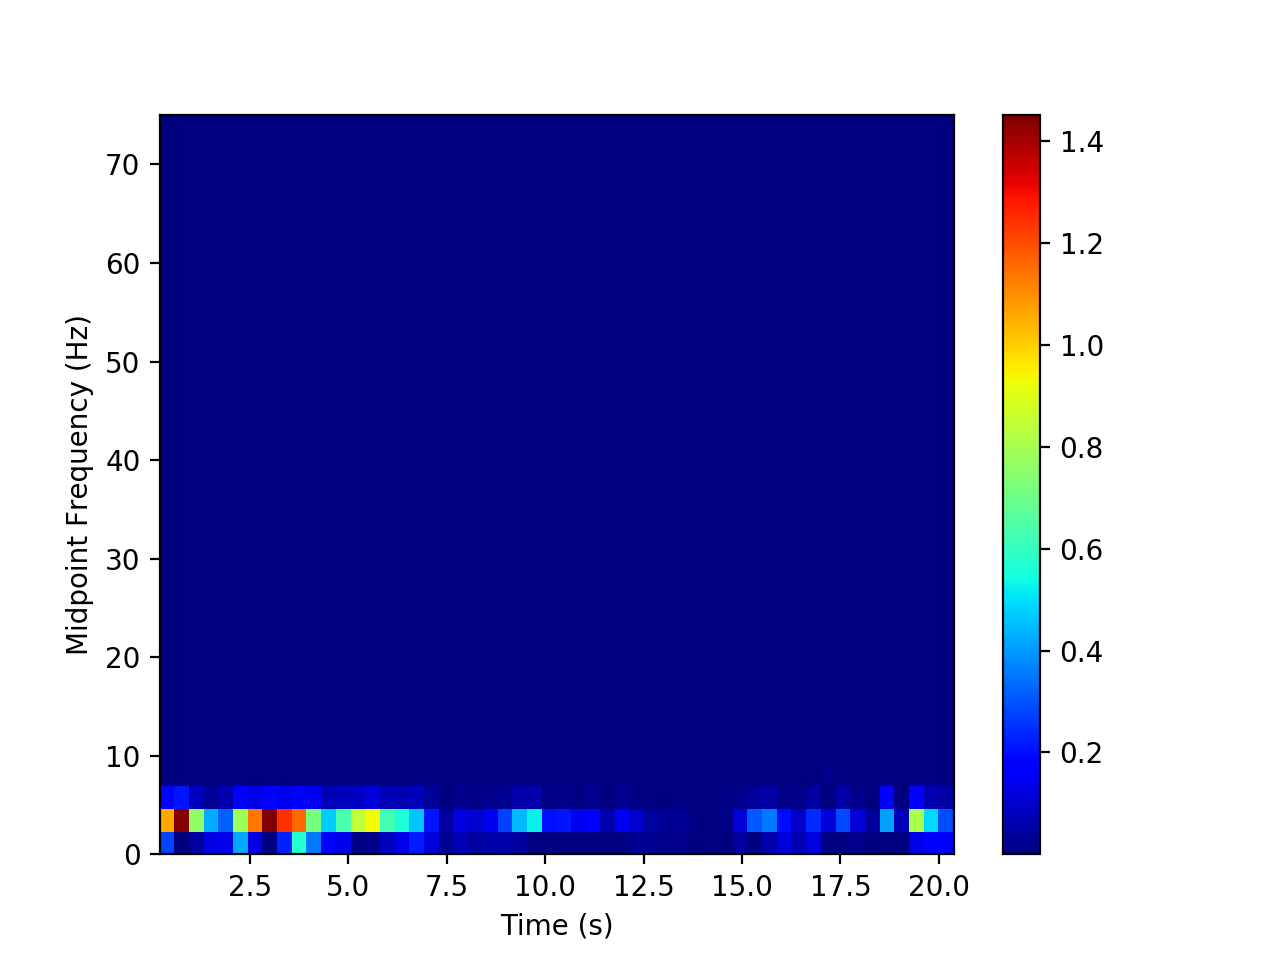

Could not find time equal to 6.19. Check framerate and retry.
Could not find time equal to 6.56. Check framerate and retry.
Could not find time equal to 7.31. Check framerate and retry.


<IPython.core.display.Javascript object>


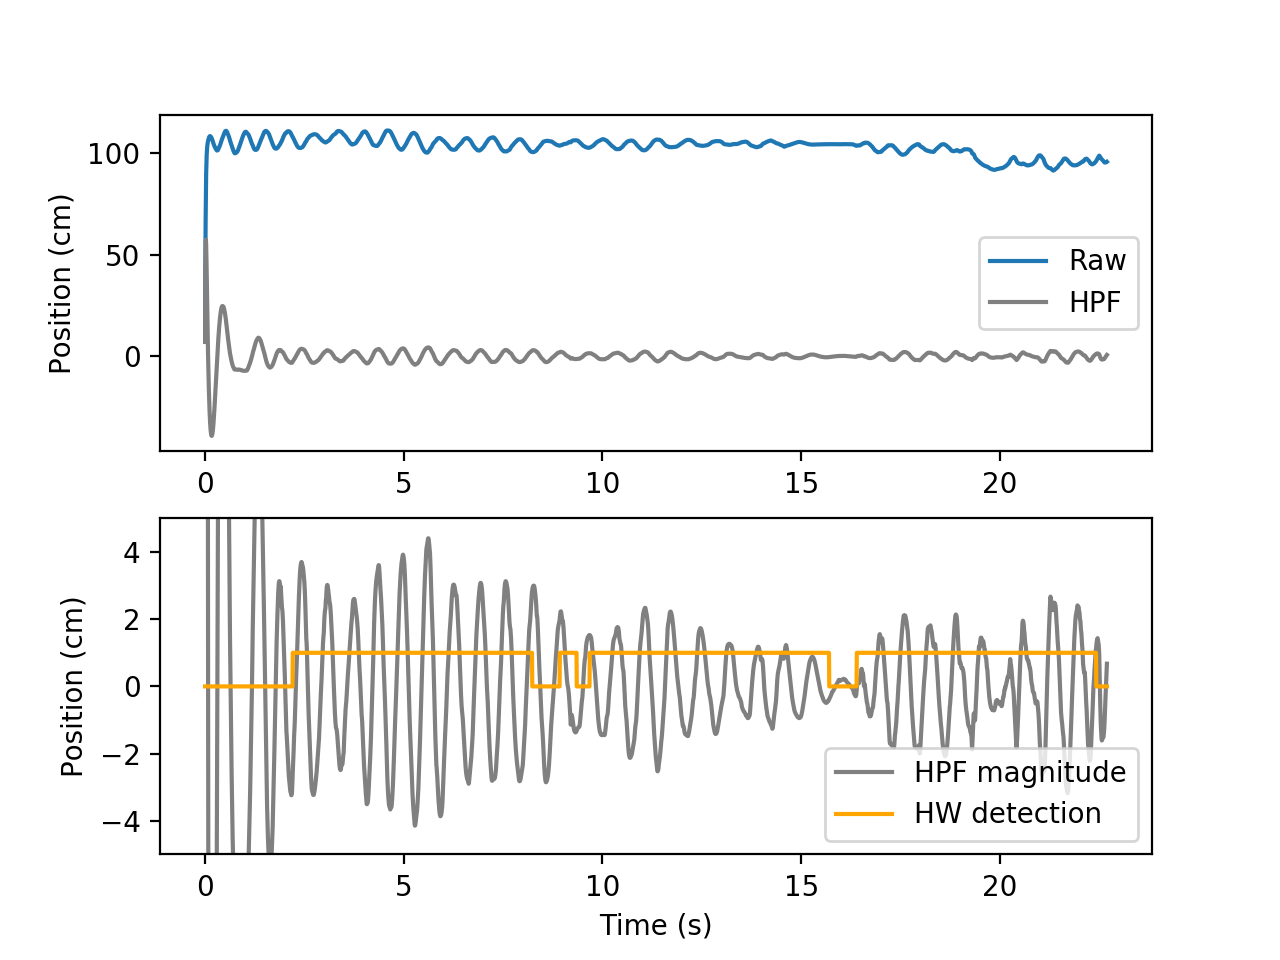

In [287]:
#Run for both data sets
os.chdir('/Users/sazamore/Documents/headwagtrials/')
files = glob.glob('*.p')
# for m in range(len(files)):
m = 8
filename = files[m]
view_distance = []
ID, raw_pd, mid_KF, mid_mag, mid_norm=opencsv(filename)
print("File '{}' opened".format(files[m]))

fs = 150
# frames = raw_mat[:,8] #if errors, try [:,0]
# frames = np.array(raw_pd['frames'].astype(float)).astype(int)
frames = np.array(range(len(mid_norm)))
T = frames/fs

HPF_y = butter_highpass_lfilter(raw_pd[1],.2,25)
len(HPF_y)

[hw_bool, HPF_mid, head_wag_idx, junk] = findHW(raw_pd[1],thresh = 0.01,fs=150)

plt.figure()
plt.subplot(211)
# plt.plot(T,mid_norm, label = 'Vel magnitude')
plt.plot(T,raw_pd[1],label='Raw') #label = 'Norm')
plt.plot(T,HPF_y,'gray',label = 'HPF')
plt.ylabel('Position (cm)')


plt.legend()
plt.subplot(212)
plt.plot(T,HPF_y, 'gray',label ='HPF magnitude')
#plt.plot(hw_loc, spDens[hw_loc],'.')
plt.plot(T,hw_bool,'orange', label = "HW detection")
# plt.plot(T,np.abs(analytic_signal), label = "Envelope")
plt.ylabel('Position (cm)')
plt.ylim((-5,5))
plt.legend()
plt.xlabel('Time (s)')

In [288]:
analytic_signal = hilbert(HPF_y)
amplitude = np.mean(np.abs(analytic_signal[hw_bool]))
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
hw_mfreq = np.mean(junk)#np.mean(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)
hw_sfreq = np.std(junk)#np.std(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)

# amplitude = np.mean(np.abs(mid_mag))
amp_s = np.std(np.abs(analytic_signal[hw_bool]))#np.std(np.abs(mid_mag))

# hw_spDens, 
hw_mfreq, amplitude, amp_s, 

(2.34375, 2.151934103592819, 0.98756916982918574)

In [289]:
#get onset and offsets of head wags, number of hw events, and duration
hw_on = np.where(np.diff(hw_bool.astype(int))==1)[0]+1
hw_off = np.where(np.diff(hw_bool.astype(int))==-1)[0]

num_events = len(hw_on)-1 #skip the first detection event, it's usually noise.
duration = (hw_off[1:]-hw_on[1:])/fs #duration of events, in seconds

view_distance = []
hw_amp = []
hw_freq = []
for i in range(len(hw_on)):
    if raw_pd[0][i]<= distances[m]:#gap_hw['Distance'][m][0]:
        analytic_signal = hilbert(HPF_y[hw_on[i]:hw_off[i]])
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        hw_mfreq = np.mean(np.diff(instantaneous_phase)/(2.0*np.pi) * fs)
        hw_sfreq = np.std(np.diff(instantaneous_phase)/(2.0*np.pi) * fs)

#         print(hw_mfreq)
        #viewing distance is the position at the onset of the head wag
        view_distance.append([np.abs(np.sqrt((raw_pd[0][hw_on[i]]-distances[m])**2 + (raw_pd[1][hw_on[i]]-distances[m])**2))/10])
        hw_amp.append([np.mean(np.abs(analytic_signal)),np.std(np.abs(analytic_signal))])
        idx1 = int(np.where(head_wag_idx==hw_on[i])[0])
        try:
            idx2 = int(np.where(head_wag_idx==hw_on[i+1])[0]-1)
        except:
            idx2 = len(junk)-1
#         print idx1,idx2
        hw_freq.append([hw_mfreq,hw_sfreq])#[np.mean(junk[idx1:idx2]),np.std(junk[idx1:idx2])])

    

In [283]:
hw_mfreq,hw_sfreq,hw_amp, view_distance, duration

(1.9934116665608417,
 3.4932049403590355,
 [[2.8597579758395733, 0.88349105709870568],
  [2.1138335412803402, 0.62390166953127646],
  [2.2632845942895159, 1.1569737997291929]],
 [[24.128440952160531], [19.17300374604649], [18.610663840049575]],
 array([  0.42      ,  13.48666667]))

In [259]:
if m ==0:
    gap_hw = {'ID':[],'file':[],'hw_view':[],'num_events':[],'duration':[],'hw_on':[],'hw_off':[],'head_freq':[],'head_amp':[]}


In [290]:
num_events, duration
gap_hw['ID'].extend(list(np.ones(num_events)*ID))
gap_hw['file'].extend([filename])
gap_hw['hw_view'].extend([view_distance])
gap_hw['num_events'].extend(list(np.ones(num_events)*num_events))
gap_hw['duration'].extend(duration)
gap_hw['hw_on'].extend(hw_on)
gap_hw['hw_off'].extend(hw_off)
gap_hw['head_freq'].append(hw_freq)
# gap_hw['std_freq'].append(np.std(junk))
gap_hw['head_amp'].append(hw_amp)
# gap_hw['std_amp'].append(amp_s)

#save dict to csv
with open('gap_hw_data.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in gap_hw.items():
        writer.writerow([key, value])

In [156]:
distances = [60.46038727,
106.0612424,
143.4760643,
199.531303,
138.6820667,
138.8132424,
169.3138415,
167.3342909,
116.1339212]

<IPython.core.display.Javascript object>


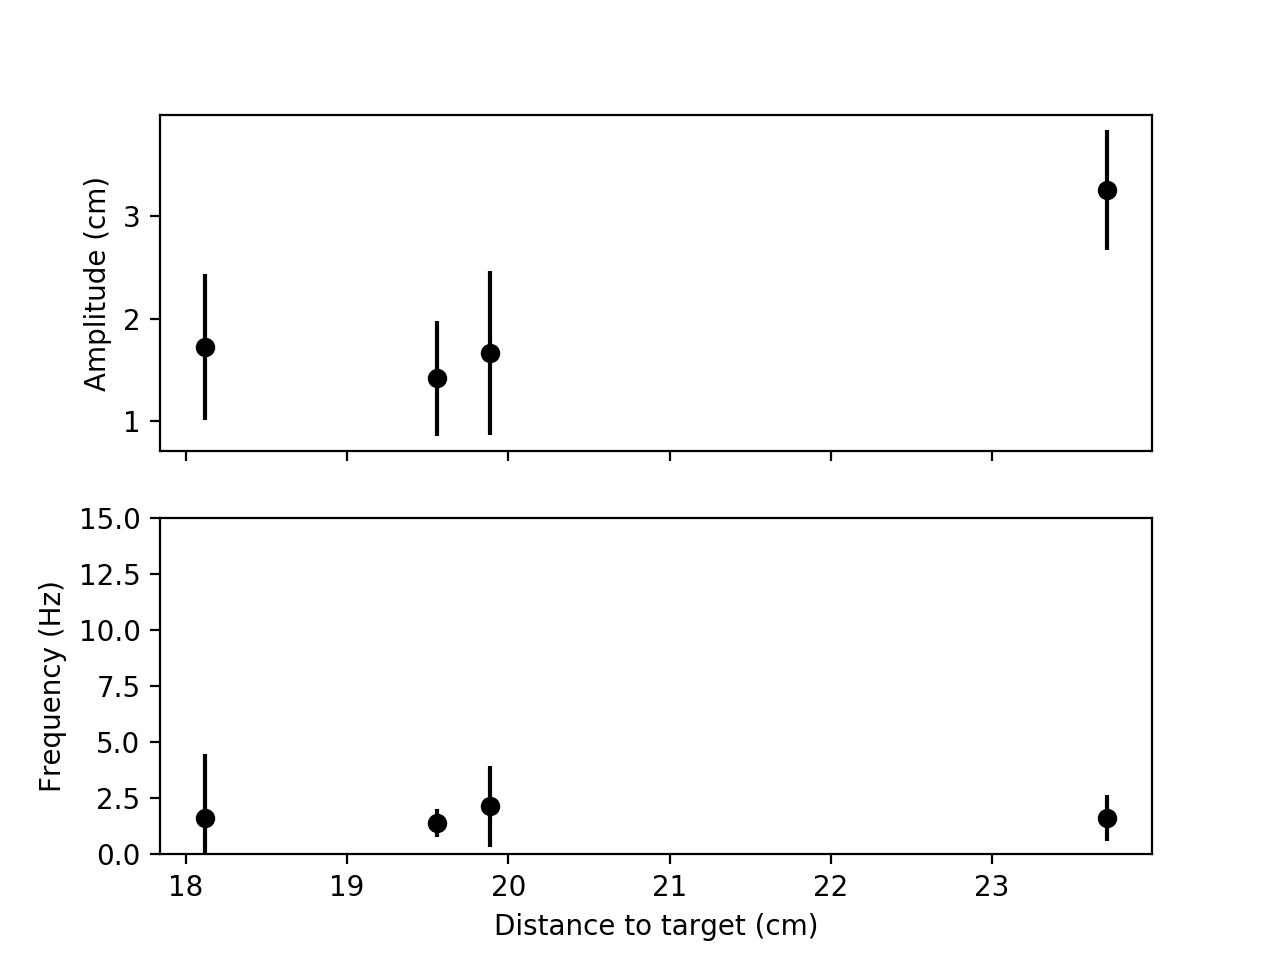

In [135]:
plt.figure()

for i in range(len(view_distance)):
    plt.subplot(211)
    plt.errorbar(view_distance[i], hw_amp[i][0],yerr=hw_amp[i][1],fmt='ko')
    ticks = plt.gca()
    ticks.axes.xaxis.set_ticklabels([])
    plt.ylabel('Amplitude (cm)')
    plt.subplot(212)
    plt.errorbar(view_distance[i], hw_freq[i][0],yerr=hw_freq[i][1],fmt='ko')
    plt.ylim((0,15))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Distance to target (cm)')
# plt.subplot(313)
# plt.hist(view_distance, np.transpose(hw_amp)[0])

In [1279]:
# drop_idx = list(np.where(bin_means)[0])
# drop_idx = [0,1,2,3,4,5,6,7,8,9,10,12,13,21,24]
# drop_idx = [0,1,2,3,4,5,6,7,8,9,10]
drop_idx = [0,1,2,3,4,5,8,9,10,12,13,21,24]#duration

bin_means[drop_idx]

array([ 3.82666667,  1.58666667,  5.18444444,  1.84444444,  4.274     ,
        2.93866667,  4.57555556,  2.63933333,  3.69111111,  5.43      ,
        2.01666667,  2.39333333,  0.84666667])

<IPython.core.display.Javascript object>


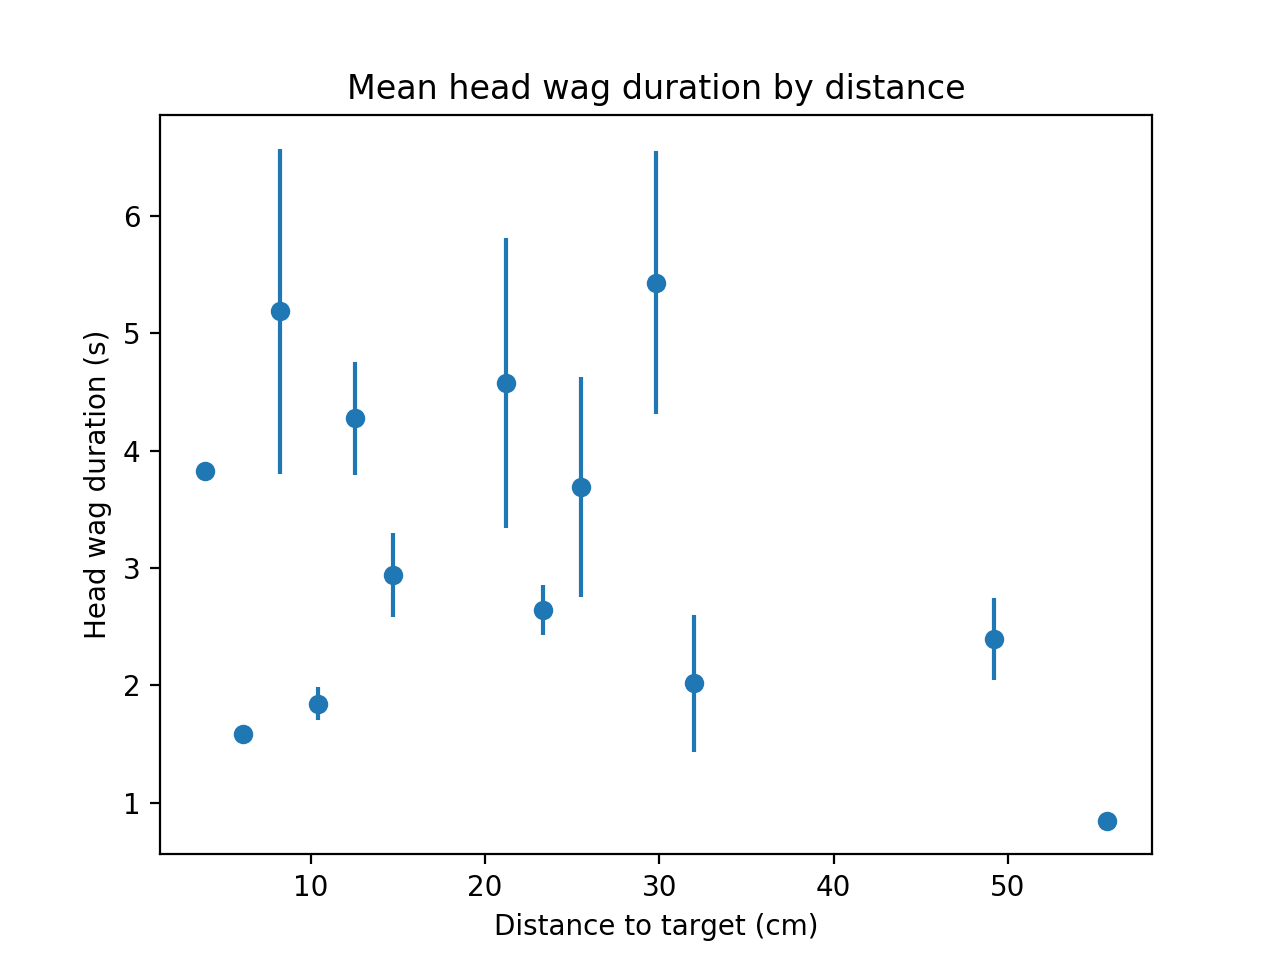

0.222198736676 -0.36345297214 -0.0326876624185 3.90898338398


In [1285]:
bin_count, bin_edges, binnumber= scipy.stats.binned_statistic(all_view,all_dur,'count',bins=25)
bin_means, bin_edges, binnumber= scipy.stats.binned_statistic(all_view,all_dur,'mean',bins=25)
bin_std, bin_edges, binnumber= scipy.stats.binned_statistic(all_view,all_dur,np.std,bins=25)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.errorbar(bin_centers[drop_idx], bin_means[drop_idx],yerr=bin_std[drop_idx]/bin_count[drop_idx],fmt='o')# colors='g', lw=2, label='binned statistic of data')
plt.title('Mean head wag duration by distance')
plt.xlabel('Distance to target (cm)')
plt.ylabel('Head wag duration (s)')
slope, intercept, r_value, p_value, std_err = stats.linregress(bin_centers[drop_idx],bin_means[drop_idx])
line = slope*bin_centers[drop_idx]+intercept
# plt.plot(bin_centers[drop_idx],line,':')
print p_value, r_value, slope, intercept

In [ ]:
bin_means, bin_edges, binnumber= scipy.stats.binned_statistic

<IPython.core.display.Javascript object>


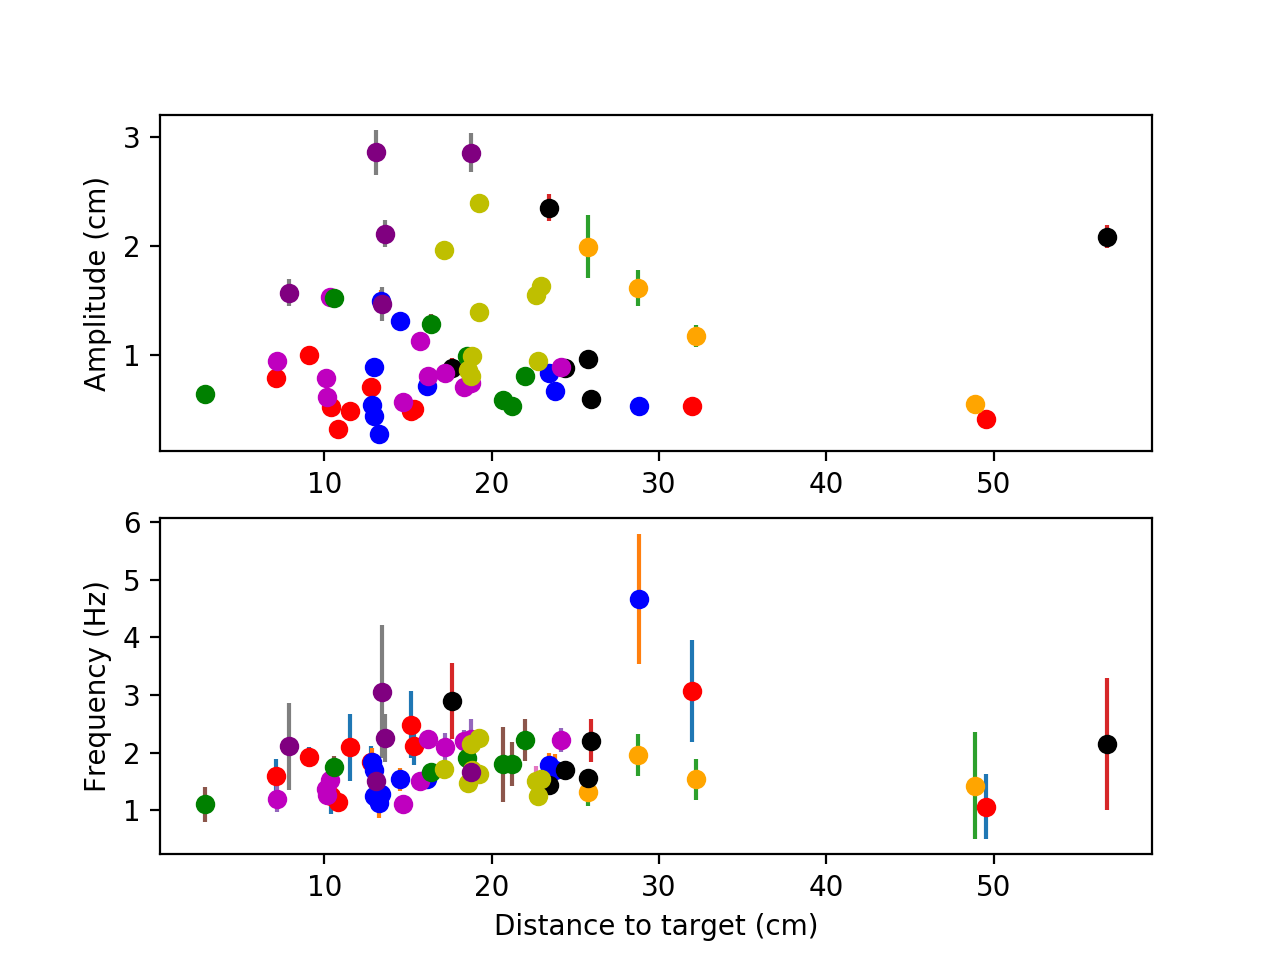

In [894]:
colors = ['r','b','orange','k','m','g','y','purple']
plt.figure()
for j in range(len(store['ID'])):
    for i in range(len(store['view_dist'][j])):
        plt.subplot(211)
        plt.errorbar(store['view_dist'][j][i], np.transpose(store['amp'][j][i])[0],yerr=np.transpose(store['amp'][j][i])[1]/len(store['view_dist'][j][i]),fmt='o',mfc=colors[j],mec=colors[j])
        plt.ylabel('Amplitude (cm)')
#         plt.xlim([0,40])
        plt.subplot(212)
        plt.errorbar(store['view_dist'][j][i], np.transpose(store['freq'][j][i])[0],yerr=np.transpose(store['freq'][j][i])[1]/len(store['view_dist'][j][i]),fmt='o',mfc=colors[j],mec=colors[j])
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Distance to target (cm)')

In [293]:
all_dist = []
all_freq = []
all_amp = []
all_dur = []
freq_dist = []

# all_dist_lg = []
# all_freq_lg = []
# all_amp_lg = []
# all_dur_lg = []
# all_dist_sm = []
# all_freq_sm = []
# all_amp_lg = []
# all_dur_lg = []
for i in range(len(gap_hw['file'])):

    all_dist.extend(np.transpose(gap_hw['hw_view'][i])[0])
#         select = np.where(np.transpose(gap_hw['head_freq'][i])[0]>=0.2)[0]
#         freq_dist.extend(np.transpose(gap_hw['hw_view'][i])[0][select])
    all_freq.extend(np.transpose(gap_hw['head_freq'][i])[0])
    all_amp.extend(np.transpose(gap_hw['head_amp'][i])[0])
all_dur = np.array(gap_hw['hw_off'])/150-np.array(gap_hw['hw_on'])/150

In [329]:
    
slope, intercept, r_value, p_value, std_err = stats.linregress(all_dist,all_dur)
durline = slope*np.array(all_dist)+intercept
# plt.plot(bin_centers[drop_idx],line,':')
p_value,r_value

(0.7085562722048353, -0.049697302795674532)

In [ ]:
pvalue, r
N=3, n=12
durline - (0.7085562722048353, -0.049697302795674532)
ampline - (0.68856115664869888, 0.053283784832444191)
freqline - (0.001316147848077908, 0.40855124815263916)

In [358]:
1-0.40855124815263916**2

0.8330858776329206

<IPython.core.display.Javascript object>


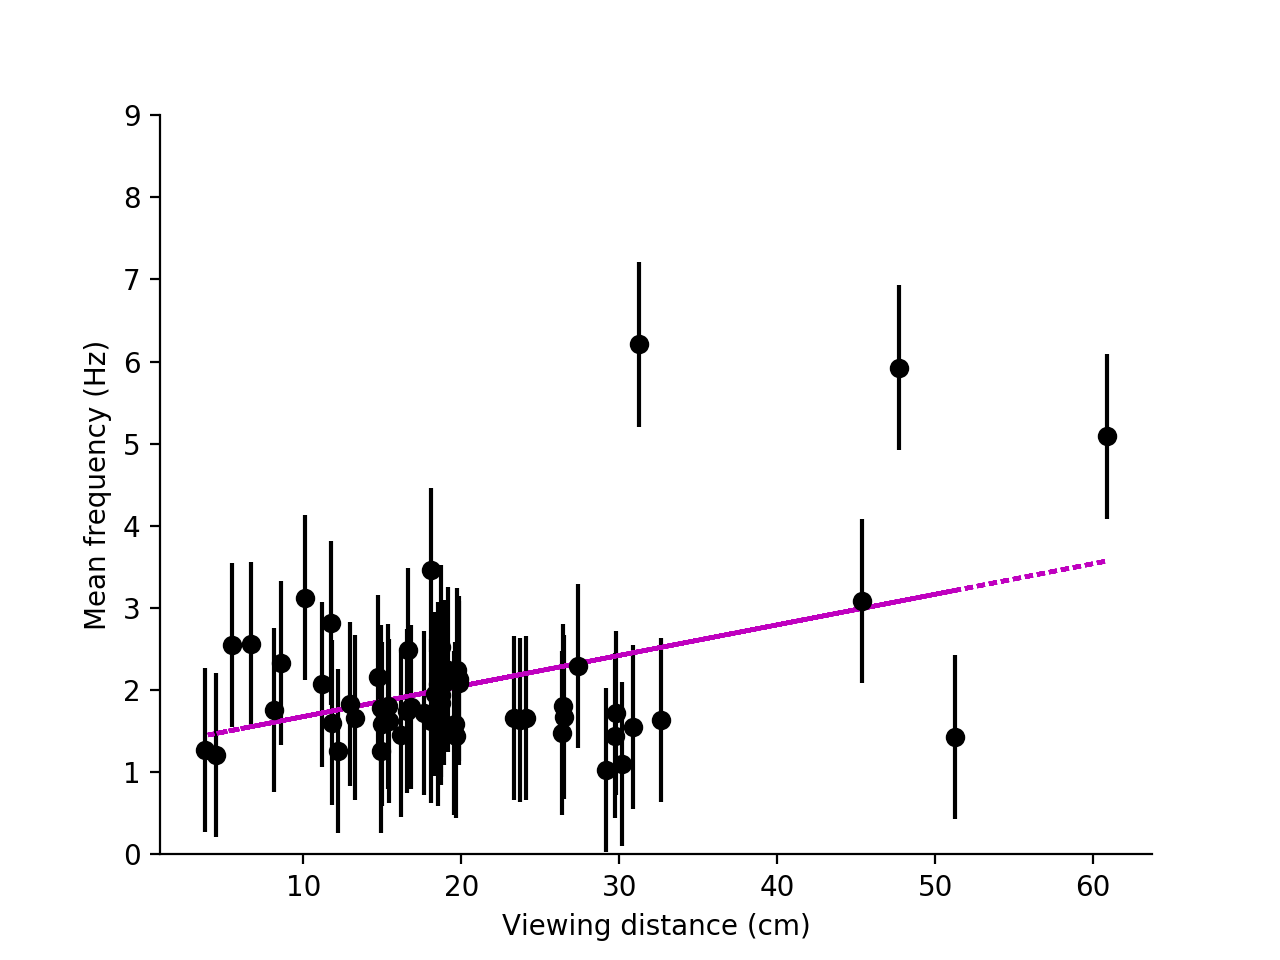

<IPython.core.display.Javascript object>


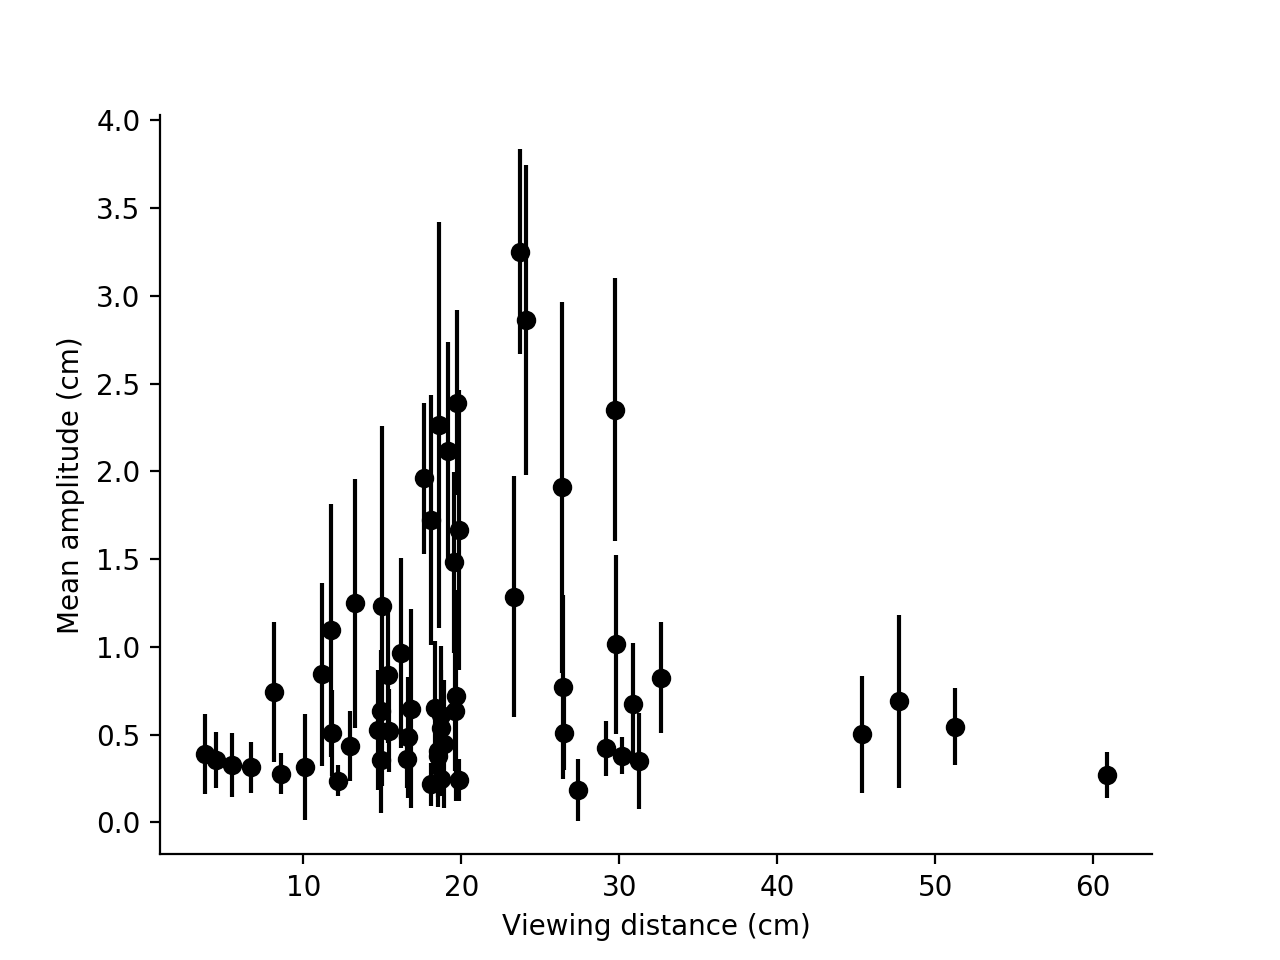

<IPython.core.display.Javascript object>


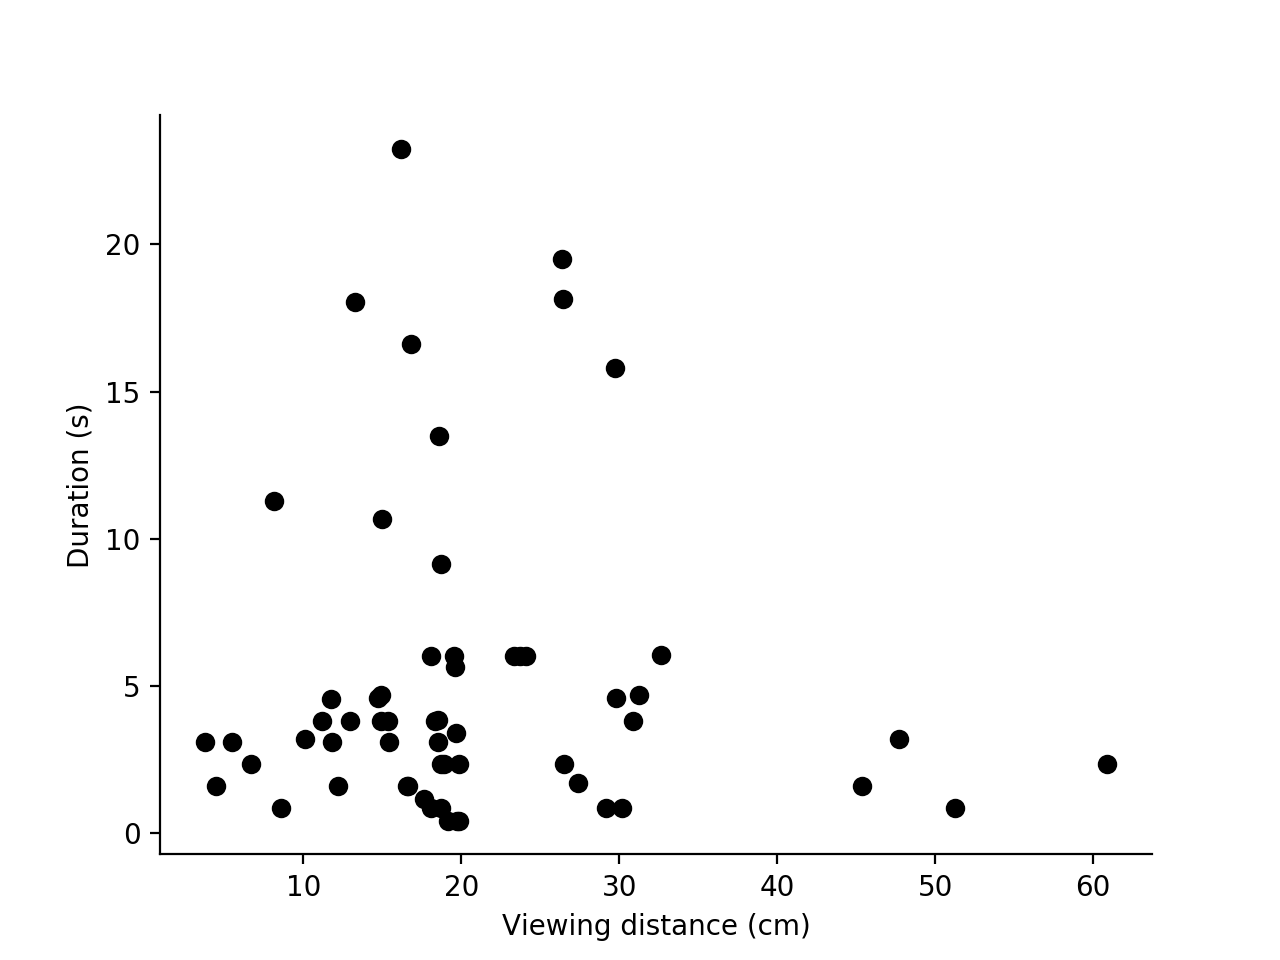

59


In [356]:
plt.figure()
ax = plt.subplot(111)
for i in range(len(gap_hw['file'])):
#     plt.title('Kinematics by viewing distance')
    plt.errorbar(np.transpose(gap_hw['hw_view'][i])[0],np.transpose(gap_hw['head_freq'][i])[0],yerr=np.transpose(gap_hw['head_freq'][i])[1]/np.transpose(gap_hw['head_freq'][i])[1],fmt='ko')
#     ticks = plt.gca()    
#     ticks.axes.xaxis.set_ticklabels([])
    plt.ylabel('Mean frequency (Hz)')
    plt.ylim((0,9))
#     plt.plot(all_dist,freqline,'m:')
    plt.xlabel('Viewing distance (cm)')
    plt.plot(all_dist,freqline,'m:')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.figure()
ax = plt.subplot(111)

for i in range(len(gap_hw['file'])):

    plt.errorbar(np.transpose(gap_hw['hw_view'][i])[0],np.transpose(gap_hw['head_amp'][i])[0],yerr=np.transpose(gap_hw['head_amp'][i])[1],fmt='ko')
    plt.ylabel('Mean amplitude (cm)')
#     ticks = plt.gca()
#     ticks.axes.xaxis.set_ticklabels([])
#     plt.plot(all_dist,ampline,'m:')
    plt.xlabel('Viewing distance (cm)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.figure()
ax=plt.subplot(111)
#     plt.plot(np.transpose(gap_hw['hw_view'][i])[0],gap_hw['duration'][i],'ko')
plt.plot(all_dist, np.array(gap_hw['hw_off'])/150-np.array(gap_hw['hw_on'])/150,'ko')
plt.ylabel('Duration (s)')
plt.xlabel('Viewing distance (cm)')
# plt.plot(all_dist,durline,'m:')
# plt.subplot(311)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print(len(all_freq))

In [341]:
print(np.mean(all_freq), np.std(all_freq))
print(np.mean(all_amp), np.std(all_amp))
print(np.mean(all_dur), np.std(all_dur))

(2.0718958024309626, 0.98558870874995286)
(0.86688731588530854, 0.71072525212465054)
(5.1542372881355938, 5.2630472376922688)


In [344]:
gap_dict = {'freq':all_freq,'amp':all_amp,'dur':all_dur,'dist':all_dist}
gap_HW = pd.DataFrame(gap_dict)
gap_HW.to_csv('gap_HW_kin.csv')

In [415]:
m = 1
view_distance = np.abs(np.sqrt((raw_pd[0][hw_on[i]]-gap_hw['Distance'][m][0])**2 + (raw_pd[1][hw_on[i]]-gap_hw['Distance'][m][1])**2))/10
view_distance

54.948937853881617

<IPython.core.display.Javascript object>


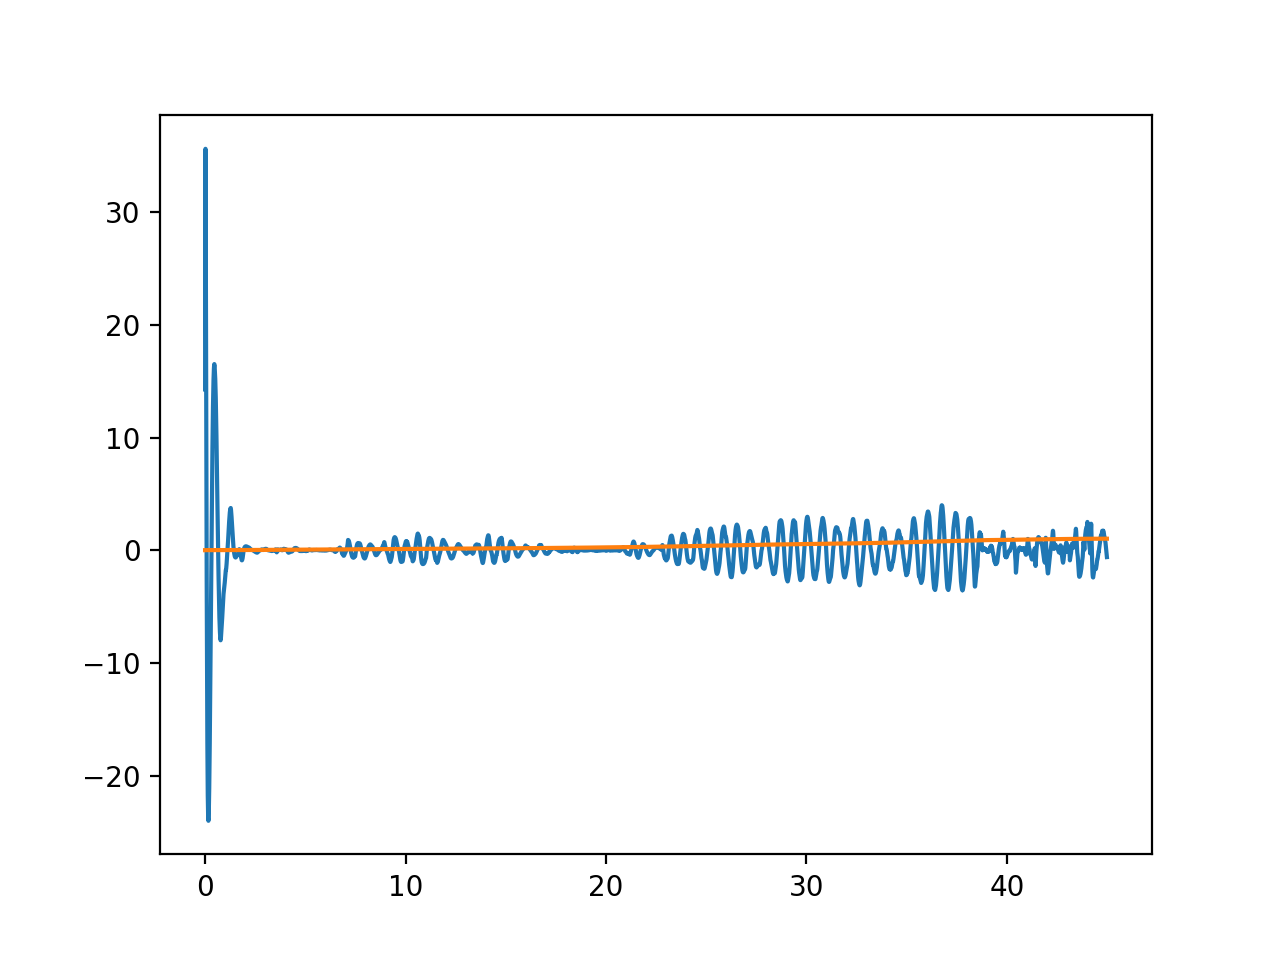

In [274]:
plt.figure()
plt.plot(T,HPF_y)
plt.plot(T,mid_mag)
# plt.plot(T,analytic_signal)
# amplitude_envelope = np.abs(analytic_signal)
# plt.plot(T,amplitude_envelope)


<IPython.core.display.Javascript object>


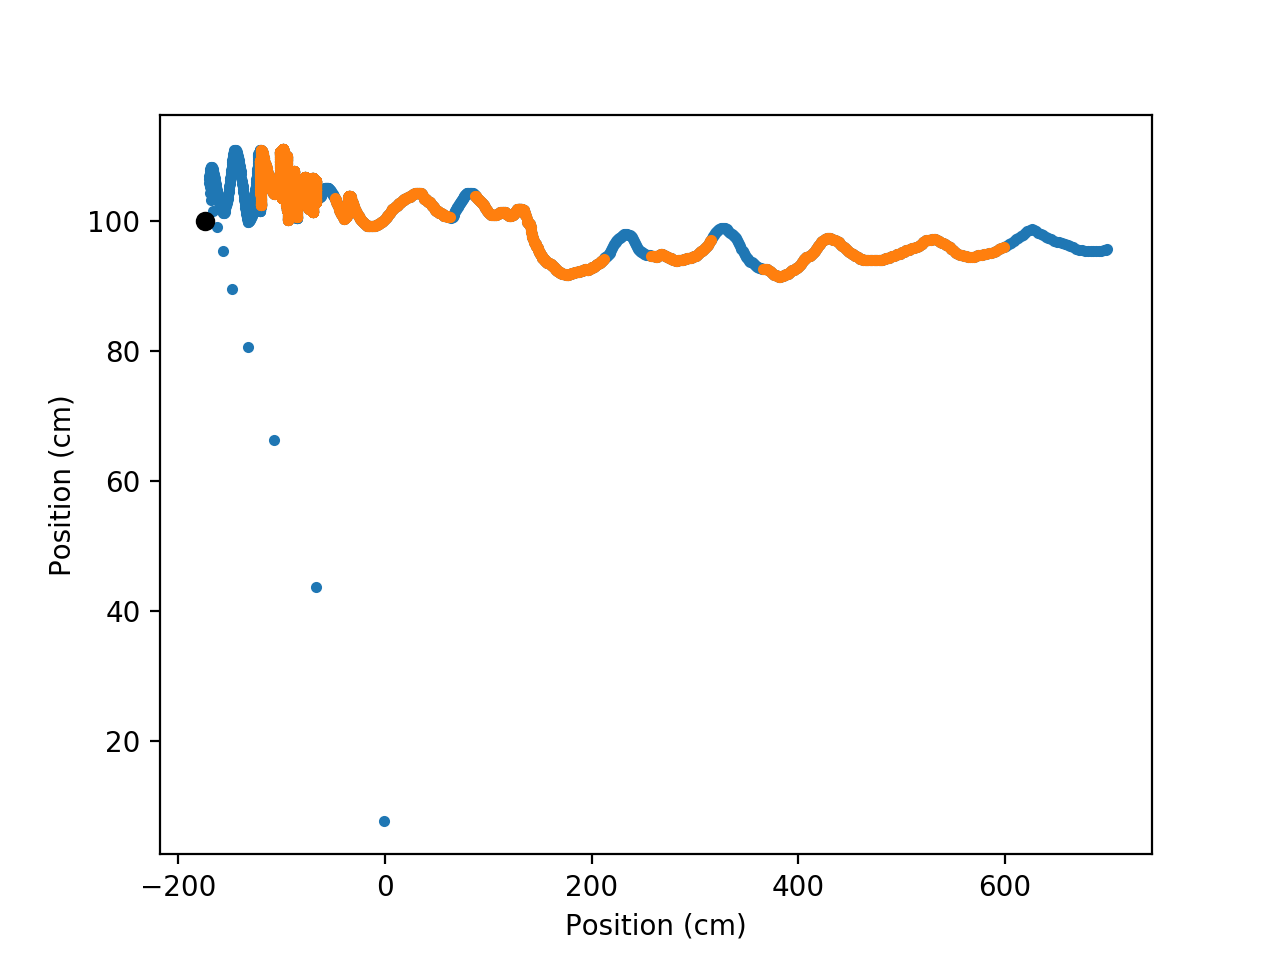

In [530]:
plt.figure()
plt.plot(raw_pd[0],raw_pd[1],'.')
plt.plot(raw_pd[0][hw_bool],raw_pd[1][hw_bool],'.')
plt.plot(gap_hw['Distance'][0][0],100,'ko')
# plt.plot(end_pt[0]/10,end_pt[1]/10,'ro')
# plt.plot(targ_pt[0]/10,targ_pt[1]/10,'ro')
plt.xlabel('Position (cm)')
plt.ylabel('Position (cm)')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<IPython.core.display.Javascript object>


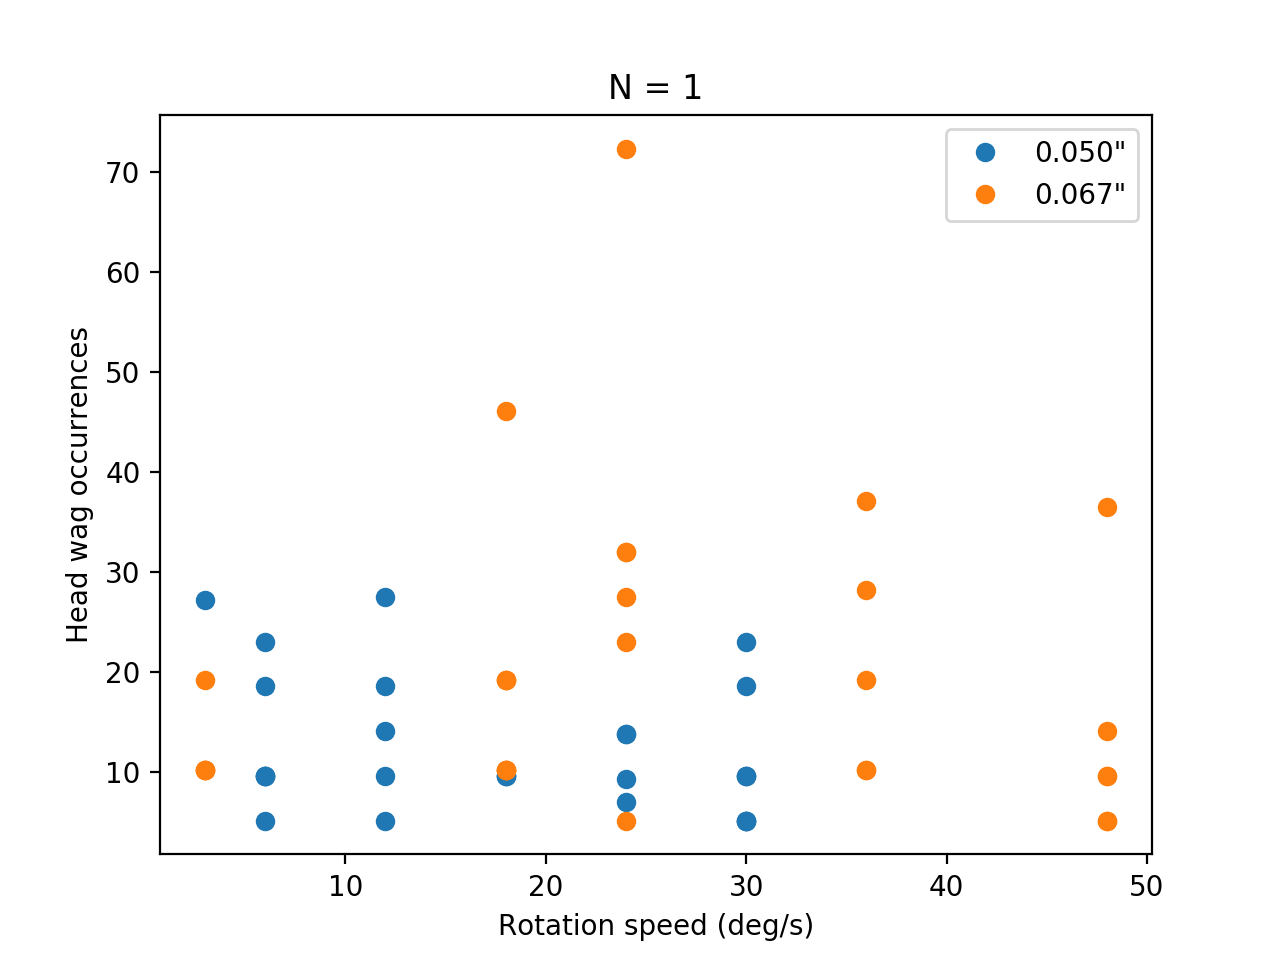

In [582]:
getitdone = pd.DataFrame([gross_hw['Date'],gross_hw['num_events'],gross_hw['Speed'],gross_hw['duration']])
getitdone = getitdone.transpose()
getitdone.columns = ['Date','num','Speed','dur']
getitdone = getitdone.sort(['Date', 'Speed'], ascending=[0, 1])

series = np.unique(getitdone['Date'])
plt.figure()
for n in series:
    plt.plot(getitdone[getitdone['Date']==n]['Speed'],getitdone[getitdone['Date']==n]['dur'],'o')
plt.xlabel('Rotation speed (deg/s)')
plt.ylabel('Head wag occurrences')
plt.legend(['0.050"','0.067"'])
plt.title('N = 1')

In [493]:
keyVals = np.unique(gross_hw['Date'])  #make series

for key in keyVals:
    colorVal = scalarMap.to_rgba(key)
    

[0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05]

<IPython.core.display.Javascript object>


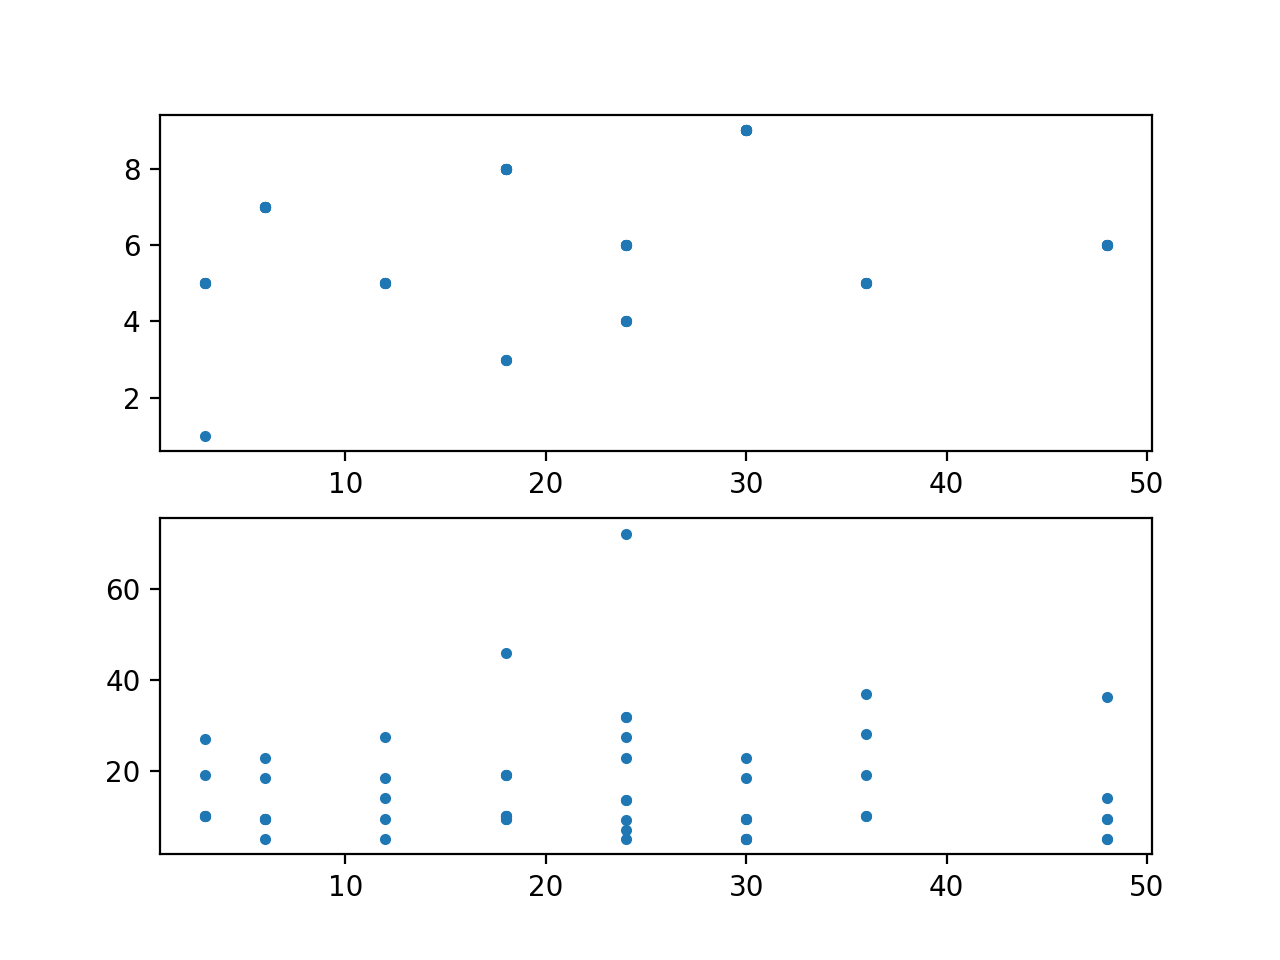

In [457]:
plt.figure()
plt.subplot(211)
plt.plot(gross_hw['Speed'],gross_hw['num_events'],'.')
plt.subplot(212)
plt.plot(gross_hw['Speed'],gross_hw['duration'],'.')

# Rotating data

<IPython.core.display.Javascript object>


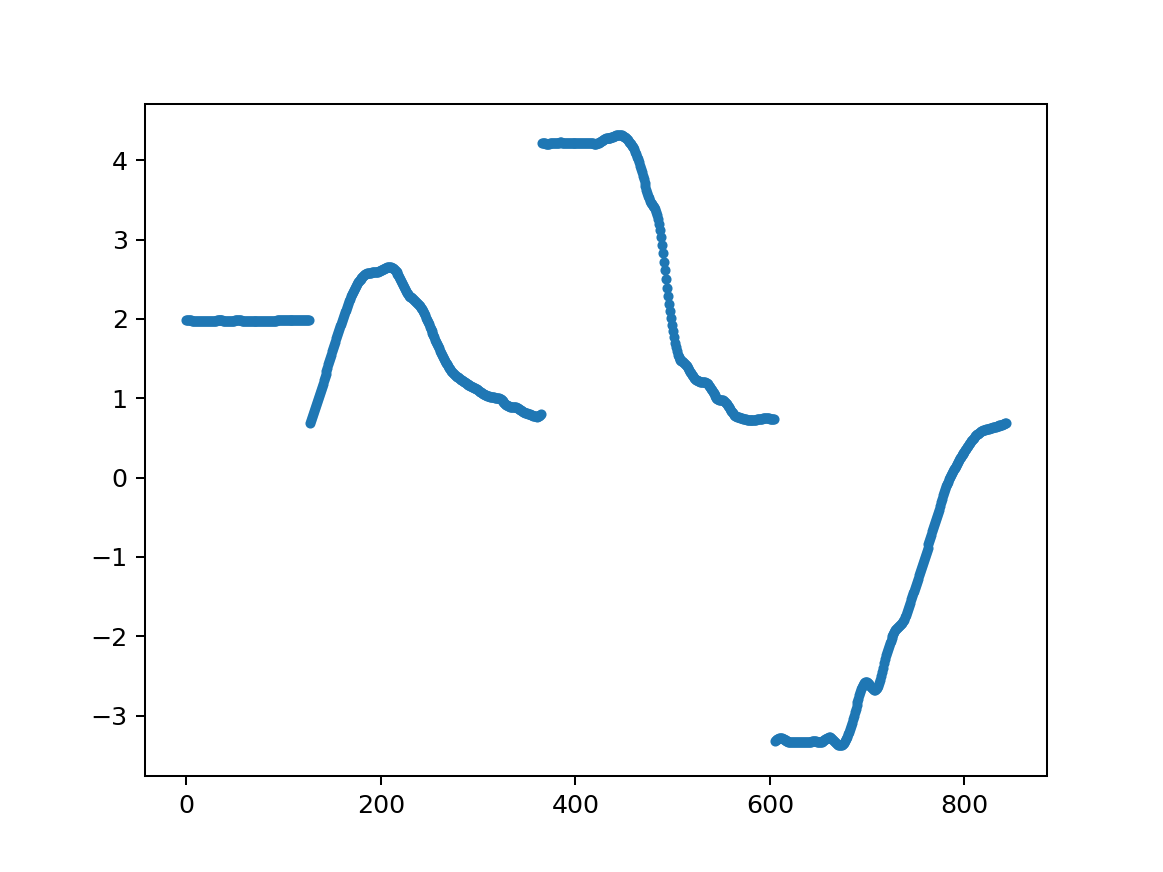

In [252]:
#Get head wag positions, and head angles #BROKEN#
hw_pos = []
hw_Rpos = []

for i in range(len(hw_on)):
#     hw_rot = np.mean(theta[hw_on[i]:hw_off[i]])
    rot_theta = np.pi-np.mean(theta[hw_on[i]:hw_off[i]])
    c, s = np.cos(rot_theta), np.sin(rot_theta)
    R = np.matrix([[c, -s], [s, c]])
    subset = mid_KF[0][hw_on[i]:hw_off[i],:2]
    hw_pos.append(subset)
    
    for row in subset:
        Rpos = R*np.matrix([row[0],row[1]]).T
        hw_Rpos.append(Rpos.tolist())

hw_Rpos = np.reshape(hw_Rpos,np.shape(hw_Rpos)[:2])
hw_pos = hw_pos

hw_Rpos

# Rpos,subset[-1]
plt.figure()
# for row in hw_pos:
#     plt.plot(row.T[0],row.T[1],'o')
plt.plot(hw_Rpos.T[1],'.')


In [232]:
#Head wag statistics - hw frequency, duration, amplitude, spatial density
analytic_signal = hilbert(hw_Rpos.T[0])
amplitude = np.mean(np.abs(analytic_signal))
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
hw_mfreq = np.mean(np.diff(instantaneous_phase)/(2.0*np.pi) * fs)
hw_sfreq = np.std(np.diff(instantaneous_phase)/(2.0*np.pi) * fs)

# amplitude = np.mean(np.abs(mid_mag))
amp_s = np.std(np.abs(analytic_signal))#np.std(np.abs(mid_mag))

# hw_spDens, 
hw_mfreq, amplitude, amp_s, #np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs

NameError: name 'hw_Rpos' is not defined

<IPython.core.display.Javascript object>


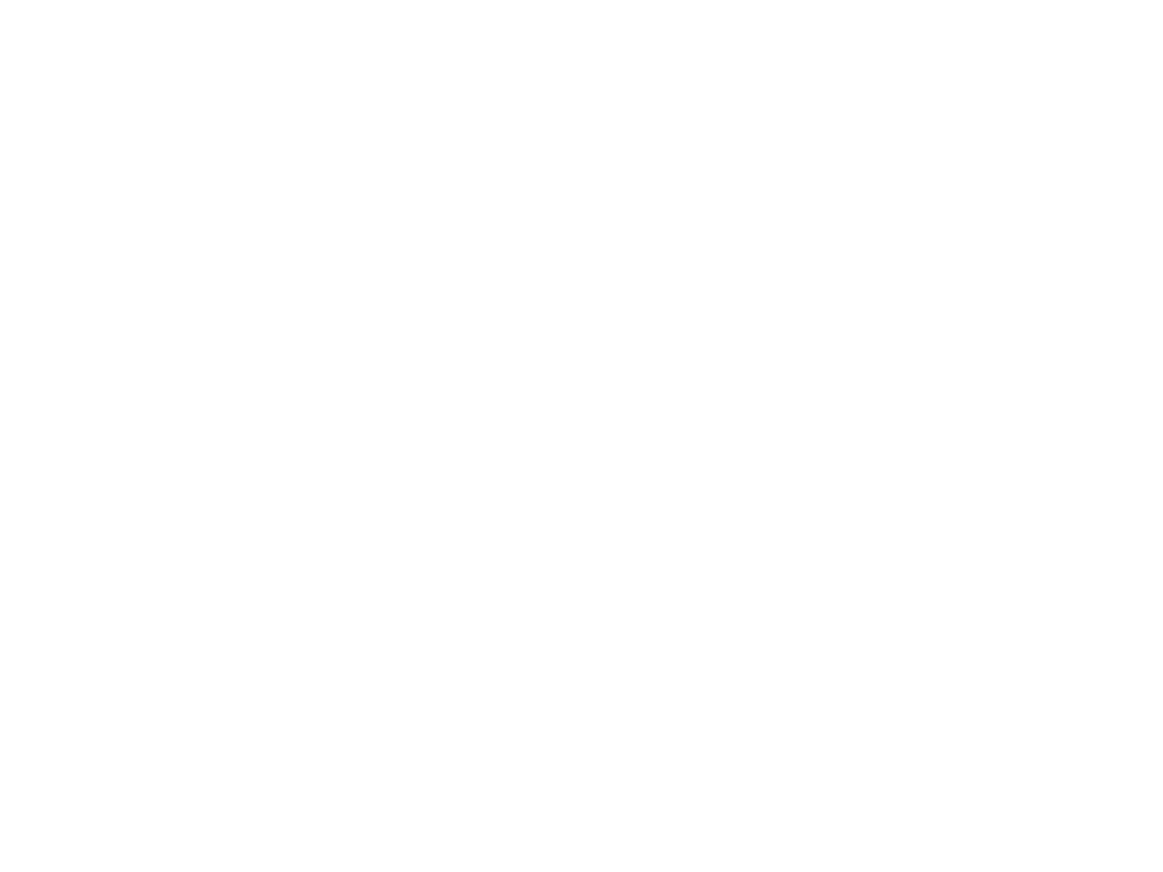

ValueError: x and y must have same first dimension, but have shapes (7557,) and (844,)

In [260]:
plt.figure()
plt.subplot(211)
plt.plot(T,mid_norm, label = 'Vel magnitude')
plt.legend()
# #plt.plot(HPF_mid)
# plt.plot(BPF_mid)
# plt.plot(hw_loc, HPF_mid[hw_loc],'.')
# plt.ylabel('Vector midpoint velocity (cm/s)')
# #plt.plot(hw_bool)
# plt.ylim((-2,12))
plt.subplot(212)
plt.plot(T,HPF_mid, label ='HPF magnitude')
#plt.plot(hw_loc, spDens[hw_loc],'.')
plt.plot(T,hw_bool, label = "HW detection")
plt.plot(T,np.abs(analytic_signal), label = "Envelope")
plt.ylabel('Vector midpoint position (cm)')
plt.ylim((-5,5))
plt.legend()
plt.xlabel('Time (s)')


<IPython.core.display.Javascript object>


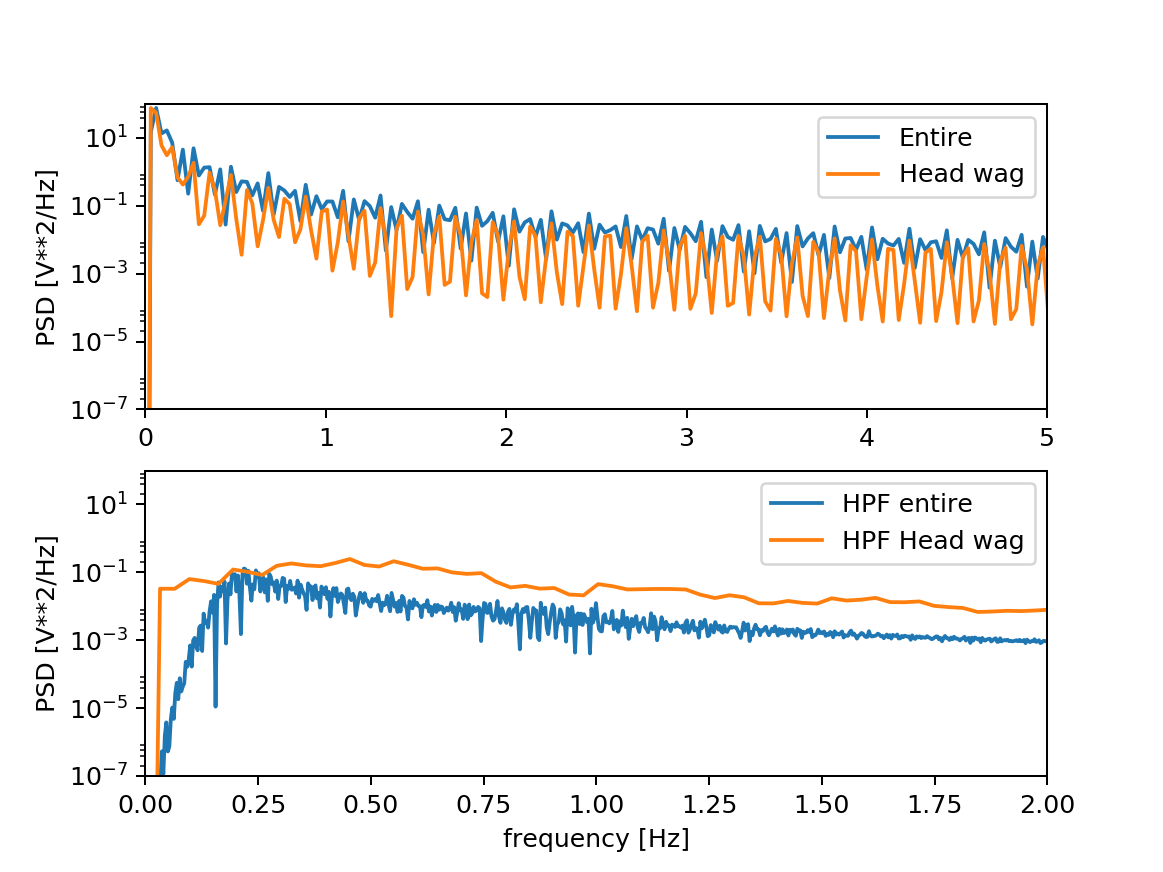

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7557 but corresponding boolean dimension is 7417


In [261]:
plt.figure()
plt.subplot(211)
f, Pxx_den = signal.periodogram(hw_Rpos.T[0], fs)
plt.semilogy(f, Pxx_den, label = 'Entire')
f, Pxx_den = signal.periodogram(hw_Rpos.T[1], fs)
plt.semilogy(f, Pxx_den, label = 'Head wag')
plt.ylim([1e-7, 1e2])
plt.xlim([0,5])
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

plt.subplot(212)
f, Pxx_den = signal.periodogram(HPF_mid, fs)
plt.semilogy(f, Pxx_den, label = 'HPF entire')
f, Pxx_den = signal.periodogram(HPF_mid[hw_bool[140:]], fs)
plt.semilogy(f, Pxx_den, label = 'HPF Head wag')

plt.ylim([1e-7, 1e2])
plt.xlim([0,2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

# Figures I need

In [ ]:
end_pt=[]
targ_pt = []

In [219]:
targ_pt, end_pt

([[199.531303, 122.9036606], [96.24976, 135.4204848]],
 [[-160.5570982, 74.74886503], [-131.5172, 143.0979576]])